<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [1]:
RANDOM_STATE = 42
N_FOLDS = 5

In [2]:
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [3]:
dataset_files = sorted(glob('chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

In [15]:
target.head()

0     4.50
1     4.45
2    42.75
3     7.00
4    10.25
Name: fare, dtype: float64

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [4]:
with open('column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [5]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [6]:
assert df.shape == (5432105, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5432105 entries, 0 to 1975107
Data columns (total 18 columns):
taxi_id                   float64
trip_start_timestamp      object
trip_end_timestamp        object
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
tips                      float64
tolls                     float64
extras                    float64
payment_type              object
company                   float64
pickup_latitude           float64
pickup_longitude          float64
dropoff_latitude          float64
dropoff_longitude         float64
dtypes: float64(15), object(3)
memory usage: 787.4+ MB


**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- **<font color='green', size=4>tips</font>**
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- **<font color='green', size=4>логарифмирование</font>**
- никакие

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


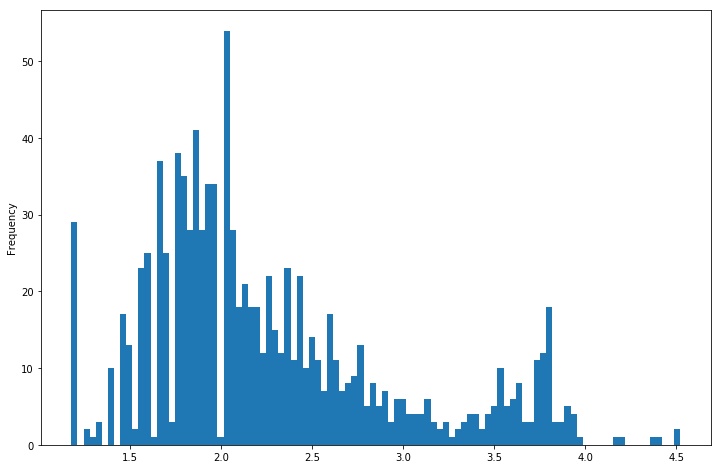

In [7]:
target_2 = np.log(target)
target_2.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

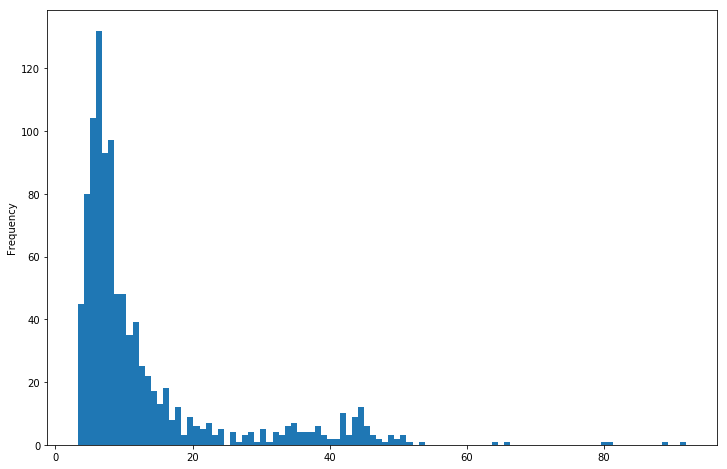

In [8]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- **<font color='green', size=4> 43.66</font>**

In [10]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()

In [37]:
pickup_dropoff.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,199.0,510.0,199.0,510.0
3,686.0,500.0,686.0,500.0
5,599.0,346.0,660.0,120.0
7,527.0,24.0,527.0,24.0
8,210.0,470.0,744.0,605.0


In [40]:
from geopy.distance import great_circle

In [45]:
for i in column_remapping:
    print(i)

taxi_id
company
pickup_census_tract
dropoff_census_tract
pickup_latitude
pickup_longitude
dropoff_latitude
dropoff_longitude


In [41]:
distance = []

for i, row in enumerate(pickup_dropoff.itertuples(), 1):
    pick1 = column_remapping['pickup_latitude'][(row.pickup_latitude.astype(int)).astype(str)]
    pick2 = column_remapping['pickup_longitude'][(row.pickup_longitude.astype(int)).astype(str)]
    pickup = (pick1, pick2)
    
    drop1 = column_remapping['dropoff_latitude'][(row.dropoff_latitude.astype(int)).astype(str)]
    drop2 = column_remapping['dropoff_longitude'][(row.dropoff_longitude.astype(int)).astype(str)]
    dropoff = (drop1, drop2)
    
    distance.append(great_circle(pickup, dropoff).km) 

In [43]:
print("Max distance: ", max(distance))

Max distance:  43.662892734777216


Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [44]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

907.237431436
Wall time: 50.7 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- **<font color='green', size=4>не зафиксирован random seed</font>**
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

          tips  tolls  trip_seconds  trip_miles
0         0.00    0.0         180.0        0.40
1         4.45    0.0         240.0        0.70
2         5.00    0.0           0.0        0.00
3         0.00    0.0         480.0        1.10
4         0.00    0.0         480.0        2.71
5         0.00    0.0        1080.0        6.20
6        12.00    0.0        1500.0       18.40
7         0.00    0.0          60.0        0.20
8         2.00    0.0         180.0        0.00
9         0.00    0.0           0.0        0.00
10        1.00    0.0         480.0        1.30
11        0.00    0.0         420.0        0.00
12        5.18    0.0        1380.0        5.10
13        0.00    0.0         420.0        0.00
14        0.00    0.0         480.0        0.10
15        0.00    0.0         720.0        0.00
16        0.00    0.0         720.0        2.20
17        0.00    0.0         300.0        0.80
18        0.00    0.0         420.0        0.00
19        3.00    0.0         660.0     

877.71181818510013

**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- **<font color='green',size=4>tips</font>**
- tolls 
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

In [103]:
# tips убрали -> 908.72283604418749
# tolls убрали -> 719.77390306802215
# trip_seconds убрали -> 905.27410823201228
# trip_miles убрали -> 879.31395826335847

In [52]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

879.31395826335847

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [53]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

Wall time: 3min 2s


In [60]:
for i, t in enumerate((t1, t2, t3, t4)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_data_changed = X_data.copy()
        X_data_changed['time'] = t  
        #print(t)
        mask = np.isnan(target)

    X_data = X_data_changed[~mask]
    y_data = target[~mask]

    pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
        .mean())

0          2
1          4
2          6
3          5
4          3
5          4
6          3
7          1
8          4
9          3
10         0
11         2
12         2
13         4
14         6
15         6
16         0
17         4
18         0
19         4
20         2
21         4
22         5
23         4
24         1
25         3
26         5
27         6
28         5
29         6
          ..
1975078    5
1975079    1
1975080    1
1975081    2
1975082    6
1975083    2
1975084    1
1975085    4
1975086    0
1975087    0
1975088    0
1975089    5
1975090    2
1975091    0
1975092    5
1975093    2
1975094    1
1975095    1
1975096    3
1975097    3
1975098    5
1975099    4
1975100    4
1975101    2
1975102    4
1975103    1
1975104    4
1975105    2
1975106    5
1975107    3
Name: trip_start_timestamp, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ValueError: cannot reindex from a duplicate axis

** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- новые признаки не улучшают модель, т.к. такова природа данных
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев
- ** <font color='green', size=4>использовать метаданные о модели телефона пассажира</font> **
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

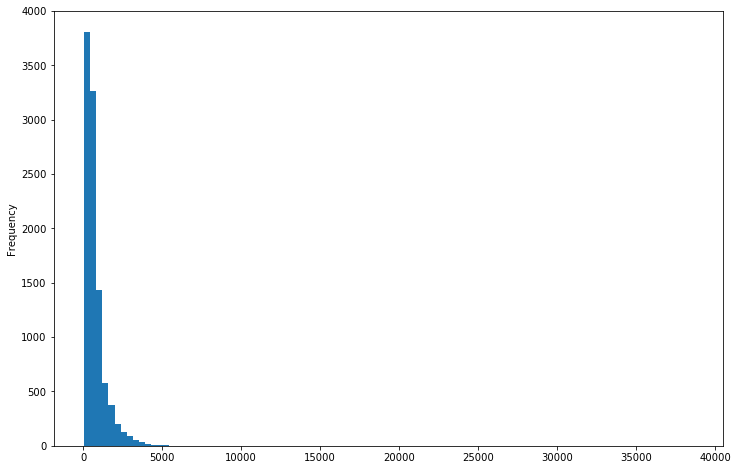

In [118]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

Wall time: 0 ns


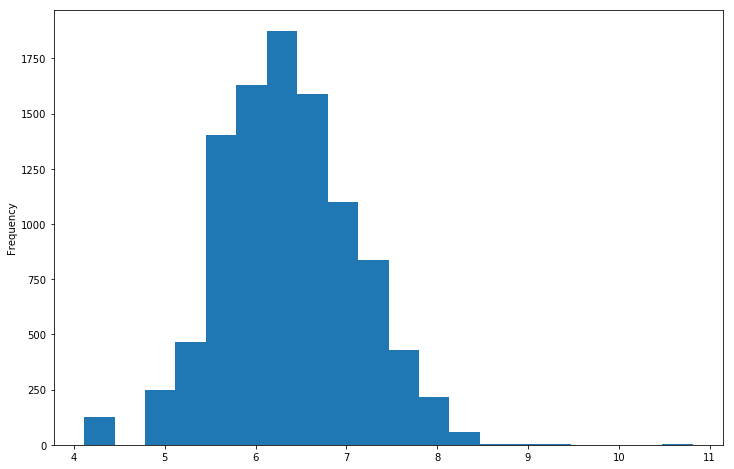

In [125]:
%time
seconds.sample(10000).apply(lambda x: 
                            np.log(x + 1)).plot(kind='hist', bins=20);

Wall time: 0 ns


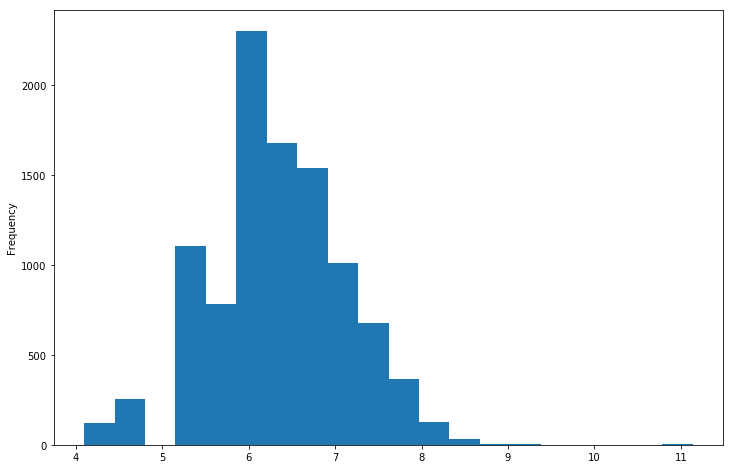

In [126]:
%time
seconds.sample(10000).apply(lambda x: 
                            np.log(x)).plot(kind='hist', bins=20);

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- **<font color='green', size=4>чтобы запутать читателей</font>**
- чтобы получить бимодальное распределение
- для скорости вычисления
- во избежание `ValueError`